# Private Support Points: Regression Examples

___

In [1]:
import numpy as np
import pandas as pd
import scipy.stats as stats
import matplotlib.pyplot as plt
import sklearn
from sklearn.datasets import load_boston, load_diabetes
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold, train_test_split

plt.style.use('ggplot')
from matplotlib import rcParams
import pdb


from sp_utils import (
    get_support_points,
    energy,
    sample_sp_exp_mech,
    sample_sp_mmd_dp_bw,
    mixture_model_likelihood,
    sample_full_set_by_diffusion)

In [2]:
def plot_nd(d, w=10, h=10, title=None):
    graph = pd.plotting.scatter_matrix(pd.DataFrame(d), figsize=(w, h));
    if title:
        plt.suptitle(title)
    plt.show()

In [3]:
# Test support points on multivariate Gaussian data.
if 0:
    M = 500
    D = 5
    data = np.random.normal(0, 1, size=(M, D))
    N = 100
    MAX_ITER = 201 #300
    LR = 5e-1 #1e1

    y_opt, e_opt = get_support_points(data, N, MAX_ITER, LR, is_tf=True,
                                      Y_INIT_OPTION='uniform', clip='data')

    plot_nd(pd.DataFrame(data), 5, 5, 'data')
    plot_nd(pd.DataFrame(y_opt), 5, 5, 'sp')

# Regression task.

In [4]:
def test_regression(_X, _Y):
    """Computes regression accuracy, averaged over multiple runs.
    
    Each run computes accuracy with k-fold cross validation.
    
    Args:
      X: Feature variables
      Y: Response variable.
    """
    num_runs = 10
    num_folds = 10
    results = []
    
    def regress(X_train, X_test, Y_train, Y_test):
        # Fits linear model given a train-test split.
        lm = LinearRegression()
        lm.fit(X_train, Y_train)

        Y_pred = lm.predict(X_test)
        mse = mean_squared_error(Y_test, Y_pred)
        r2 = lm.score(X_test, Y_test)
        
        return r2

    
    for _ in range(num_runs):
        # Each run randomly permutes the data.
        permutation = np.random.permutation(len(_X))
        X = np.array(_X)[permutation]
        Y = np.array(_Y)[permutation]

        # Create folds for fitting.
        fold_results = []
        kf = KFold(n_splits=num_folds)
        kf.get_n_splits(X) 

        for train_index, test_index in kf.split(X):
            X_train, X_test = X[train_index], X[test_index]
            Y_train, Y_test = Y[train_index], Y[test_index]
            
            # Fit model with this fold.
            r2 = regress(X_train, X_test, Y_train, Y_test)
            
            # Store result for this fold.
            fold_results.append(r2)
        
        
        # Store average of fold results.
        results.append(np.mean(fold_results))

    return results

___

# Full Experiments.

### Helper functions.

In [5]:
from collections import namedtuple
Result = namedtuple('Result', 'dataset size alpha r2')


def round_binary_cols(data, binary_cols):
    """Rounds binary cols of a NumPy array."""
    for col in binary_cols:
        col_data = data[:, col]
        col_data = np.clip(col_data, 0, 1)
        col_data = np.round(col_data)
        data[:, col] = col_data
    return data


def run_experiments(dataset_name, data, _MEAN, _STD, binary_cols,
                    num_supp, alphas, max_iter, lr, num_diffusions,
                    step_size):
    """Runs panel of experiments for different number of support points
    and different alpha settings.
    
    Args:
      dataset_name: String name.
      data: NumPy array of data. NOTE: Target var must be last column [!].
      _MEAN: Float, column-wise mean of original data, for unnormalization.
      _STD: Float, column-wise std of original data, for unnormalization.
      binary_cols: List, column indices with binary variables.
      num_supp: List of support point set sizes.
      alphas: List of alphas.
      max_iter: Int, number of steps in support point optimization.
      lr: Float, learning rate of support point optimization.
      num_diffusions: Int, number of Support Point diffusions over which 
        to average regression performance.
      step_size: Float, step size of support point diffusion.
      
    Returns:
      results: List of Result objects.
    """

    results = []

    for N in num_supp:
        # Test regression on data.
        unnormalized_data = data * _STD + _MEAN
        plot_nd(unnormalized_data, 10, 10, 'Raw data')
        
        #r2_vals_true = test_regression(data[:, :-1], data[:, -1])
        r2_vals_true = test_regression(unnormalized_data[:, :-1],
                                       unnormalized_data[:, -1])
        
        true_result = Result(dataset_name, N, None, np.mean(r2_vals_true))
        results.append(true_result)

        # Compute support points.
        y_opt, e_opt = get_support_points(data, N, max_iter, lr, is_tf=True,
                                          Y_INIT_OPTION='uniform', clip='data')


        # For each alpha, compute private support points and test regression on them.
        for alpha in alphas:
            print(('\n\n---------------------------'
                   '\nRunning for N={}, alpha={}').format(N, alpha))

            # BEGIN: Compute private support points.
            dim = data.shape[1]
            ENERGY_POWER = 2

            # Define energy sensitivity for Exponential Mechanism.
            energy_sensitivity = 2 * dim ** (1. / ENERGY_POWER) * (2 * N - 1) / N ** 2
            print(('Exp(2 * U / alpha) = Exp(2 * {:.4f} / {:.2f}) '
                   '= Exp({:.3f})').format(energy_sensitivity, alpha, 
                                           2. * energy_sensitivity / alpha))

            # In each setting, run diffusion many times. Resulting r2 vals will be averaged.
            diffusion_results = []
            for i in range(num_diffusions):
                
                print('\n----------\nN={}, alpha={}, diffusion={}'.format(N, alpha, i))
                
                (y_tildes_diffusion,
                 energies_diffusion,
                 energy_errors_diffusion) = sample_sp_exp_mech(e_opt, energy_sensitivity,
                                                               data, y_opt, 'diffusion',
                                                               step_size=step_size,
                                                               num_y_tildes=1,
                                                               alpha=alpha,
                                                               diffusion_mean=True)

                private_support_points = y_tildes_diffusion[0]
                # END: Compute private support points.

                # Test regression on private support points.
                unnormalized_priv_sp = private_support_points * _STD + _MEAN
                unnormalized_priv_sp = round_binary_cols(unnormalized_priv_sp, binary_cols)
                #r2_vals_priv = test_regression(private_support_points[:, :-1],
                #                               private_support_points[:, -1])
                r2_vals_priv = test_regression(unnormalized_priv_sp[:, :-1],
                                               unnormalized_priv_sp[:, -1])
                
                
                diffusion_results.append(np.mean(r2_vals_priv))

            # Store results of diffusion runs for this N-alpha combination.
            priv_result = Result(dataset_name, N, alpha, np.mean(diffusion_results))
            results.append(priv_result)
            
            # Visualize data versus sample of private support points.
            plot_nd(unnormalized_data, 10, 10, 'Raw data')
            plot_nd(unnormalized_priv_sp, 10, 10, 'N={}, alpha={}'.format(N, alpha))

            
    return results       

## BOSTON

In [6]:
# Get Boston data.
dataset_name = 'boston'
dataset = load_boston()
d = pd.DataFrame(dataset.data)
d.columns = dataset.feature_names
d['MEDV'] = dataset.target
binary_cols = [3]
print(dataset.DESCR)
print(d.describe())

# Set up and normalize data before computing support points.
_DATA = np.concatenate((dataset.data, dataset.target.reshape(-1, 1)), axis=1)
_MEAN = np.mean(_DATA, axis=0)
_STD = np.std(_DATA, axis=0)
data = (_DATA - _MEAN) / _STD

.. _boston_dataset:

Boston house prices dataset
---------------------------

**Data Set Characteristics:**  

    :Number of Instances: 506 

    :Number of Attributes: 13 numeric/categorical predictive. Median Value (attribute 14) is usually the target.

    :Attribute Information (in order):
        - CRIM     per capita crime rate by town
        - ZN       proportion of residential land zoned for lots over 25,000 sq.ft.
        - INDUS    proportion of non-retail business acres per town
        - CHAS     Charles River dummy variable (= 1 if tract bounds river; 0 otherwise)
        - NOX      nitric oxides concentration (parts per 10 million)
        - RM       average number of rooms per dwelling
        - AGE      proportion of owner-occupied units built prior to 1940
        - DIS      weighted distances to five Boston employment centres
        - RAD      index of accessibility to radial highways
        - TAX      full-value property-tax rate per $10,000
        - PTRATIO  pu

In [7]:
# Define set of parameters to test.
num_supp = [int(len(data) / i) for i in [2, 3, 5, 10]] 
alphas = [1, 10, 100]
num_diffusions = 10
max_iter = 201
lr = 0.5
step_size = 1e-3

In [8]:
# Run experiments and print results.
if 0:
    results = run_experiments(dataset_name, data, _MEAN, _STD, binary_cols,
                              num_supp, alphas, max_iter, lr, num_diffusions,
                              step_size)
    for i in results:
        print(i)

## DIABETES

In [9]:
# Get Boston data.
dataset_name = 'diabetes'
dataset = load_diabetes()
d = pd.DataFrame(dataset.data)
d.columns = dataset.feature_names
d['TARGET'] = dataset.target
print(dataset.DESCR)
print(d.describe())
binary_cols = []

# Set up and normalize data before computing support points.
_DATA = np.concatenate((dataset.data, dataset.target.reshape(-1, 1)), axis=1)
_MEAN = np.mean(_DATA, axis=0)
_STD = np.std(_DATA, axis=0)
data = (_DATA - _MEAN) / _STD

.. _diabetes_dataset:

Diabetes dataset
----------------

Ten baseline variables, age, sex, body mass index, average blood
pressure, and six blood serum measurements were obtained for each of n =
442 diabetes patients, as well as the response of interest, a
quantitative measure of disease progression one year after baseline.

**Data Set Characteristics:**

  :Number of Instances: 442

  :Number of Attributes: First 10 columns are numeric predictive values

  :Target: Column 11 is a quantitative measure of disease progression one year after baseline

  :Attribute Information:
      - Age
      - Sex
      - Body mass index
      - Average blood pressure
      - S1
      - S2
      - S3
      - S4
      - S5
      - S6

Note: Each of these 10 feature variables have been mean centered and scaled by the standard deviation times `n_samples` (i.e. the sum of squares of each column totals 1).

Source URL:
https://www4.stat.ncsu.edu/~boos/var.select/diabetes.html

For more information see:
Bra

In [10]:
# Define set of parameters to test.
num_supp = [int(len(data) / i) for i in [5]] 
alphas = [100]
num_diffusions = 1
max_iter = 501
lr = 0.5
step_size = 1e-3

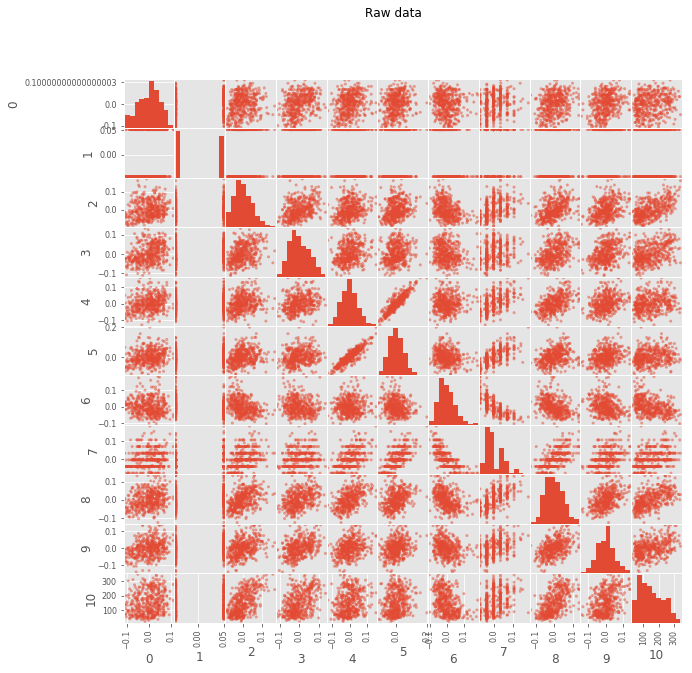


STARTING RUN. is_tf: True, y_init: uniform, clip: data, wlb: False
  [*] Using TensorFlow optimization.
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.


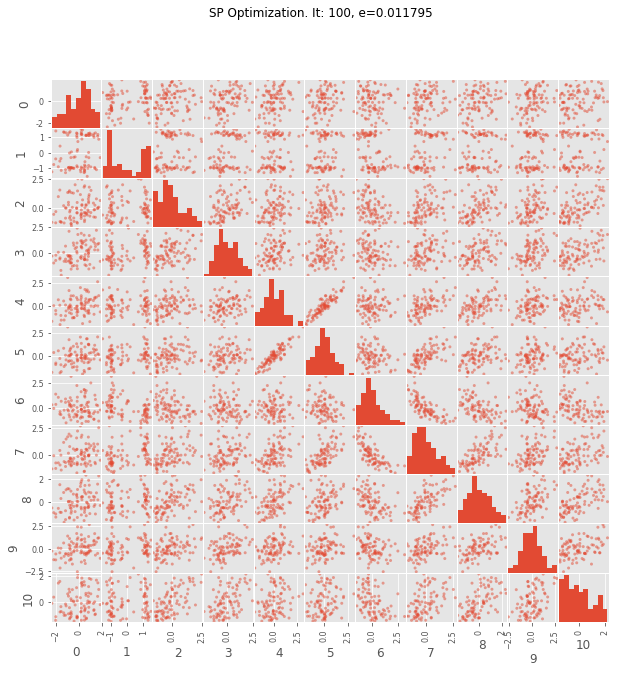

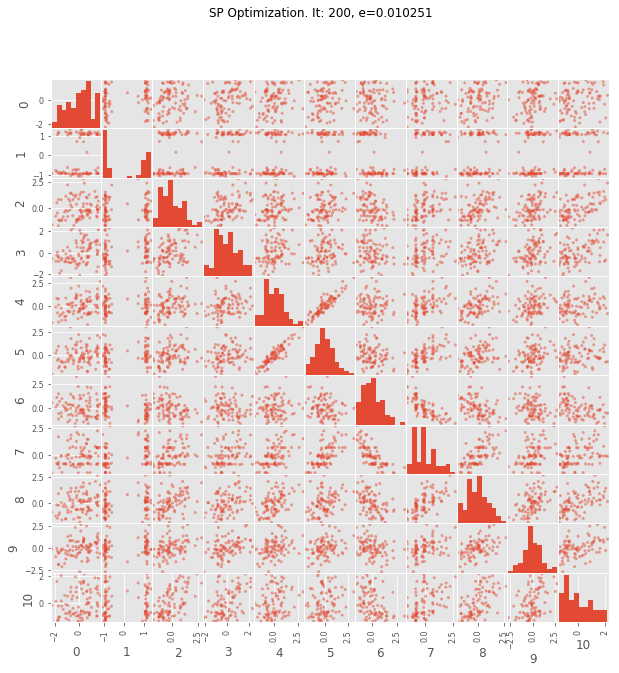

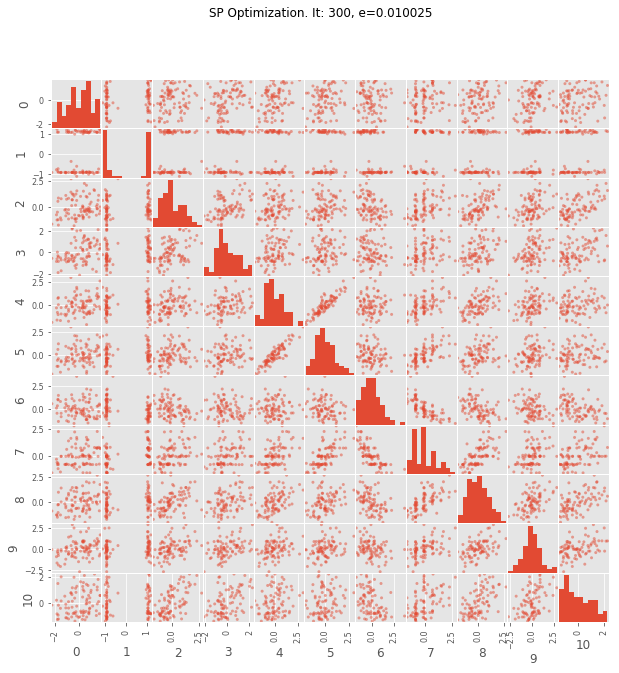

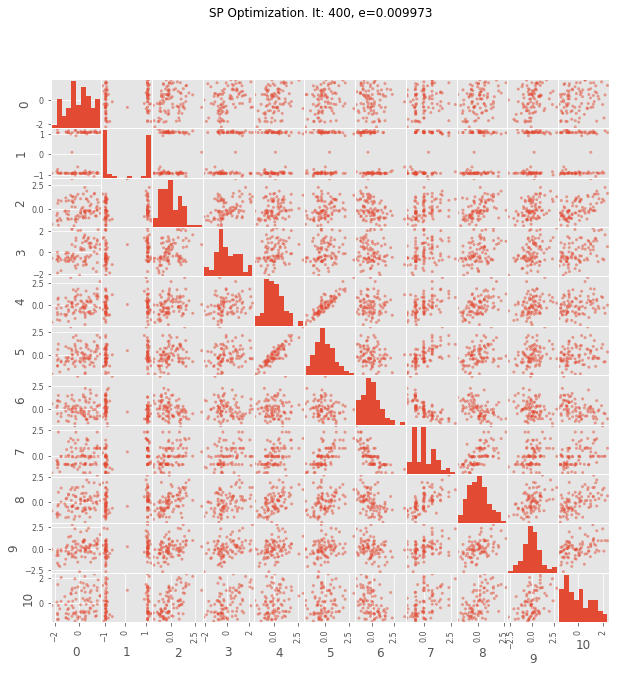

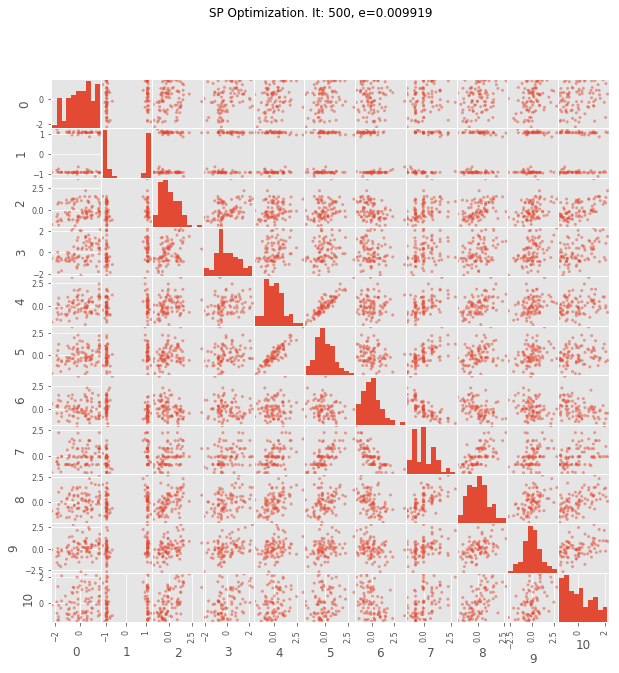

  [*] Time elapsed: 75.56


---------------------------
Running for N=88, alpha=100
Exp(2 * U / alpha) = Exp(2 * 0.1499 / 100.00) = Exp(0.003)

----------
N=88, alpha=100, diffusion=0

Pr(e) = a / (2U) * exp(- a / (2U) * e) ~ Exp(2U/a) = Exp(2 * 0.1499 / 100.000) = Exp(0.0030)

Using diffusion mean:

Exp. mean: 0.00300, e_tilde: 0.00300
  step_size_factor: 1.00000, adjusted: 0.001 -> 0.00100
  Diffusion count   173, e_opt:  0.009919, (e(y, y~) - e~) / e~ = error%: (0.00302 - 0.00300) / 0.00300 = 0.00577


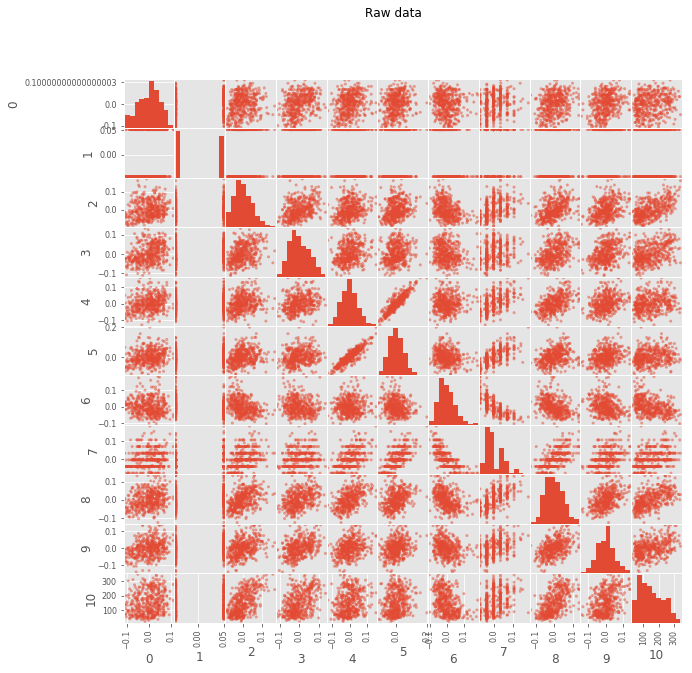

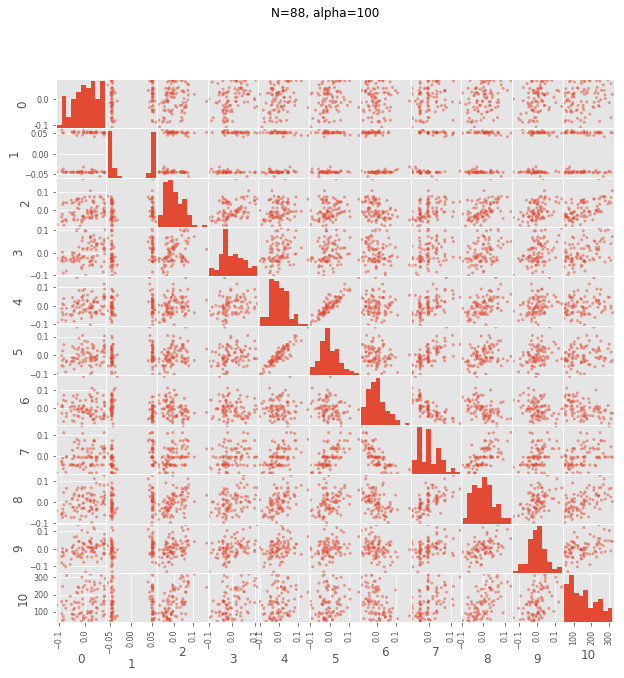

Result(dataset='diabetes', size=88, alpha=None, r2=0.47222154162908225)
Result(dataset='diabetes', size=88, alpha=100, r2=0.24850221180648213)


In [11]:
# Run experiments and print results.
results = run_experiments(dataset_name, data, _MEAN, _STD, binary_cols,
                          num_supp, alphas, max_iter, lr, num_diffusions,
                          step_size)
for i in results:
    print(i)